In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table

# from seaborn import despine
import matplotlib.pyplot as plt
plt.rc("axes.spines", top=False, right=False)

from analysis_functions import compute_gaze_influence, sci_notation, run_linear_model, compute_mean_rt, compute_p_choose_best, write_summary, make_sure_path_exists

In [3]:
make_sure_path_exists('results/linear_models')

In [4]:
np.random.seed(52) # from random.org

# Absolute model fit (out of sample prediction)
## Like and dislike condition

In [5]:
print('Assessing absolute model fit...')

Assessing absolute model fit...


### Load plot function

In [6]:
def plot_correlation(x_in, y,
                     model_names=None,
                     xlabel='',
                     ylabel='',
                     title='',
                     ci=0.95,
                     xticks=None,
                     yticks=None,
                     xticklabels=None,
                     yticklabels=None,
                     xlim=None,
                     ylim=None,
                     annotation_pos=(0.1, 0.1),
                     annotation_halign='left',
                     fontsize_title=15,
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_annotation=12,
                     plot_diagonal=False,
                     ax=None):
    
    
    x_all = x_in
    color_code = ['#4F6A9A', '#AC5255']
    # Defaults
    if ax is None:
        fig, ax = plt.subplots()
    if not isinstance(x_in, list):
        x_all = [x_in]
    if not isinstance(y, list):
        y = [y]
    if model_names is None:
        model_names = ['Model {}'.format(i)
                       for i in range(len(y))]
    
    for i, yi in enumerate(y):
        
        # Select if we load the set of observed items for like (0) or dislike (1)
        # This will depend on how we define it later.
        x = x_all[i]
        
        # Scatter
        ax.scatter(x, yi, color=color_code[i], alpha=0.5)

        # LM fit
        X = sm.add_constant(x)
        lm = sm.OLS(yi, X).fit()
        intercept, slope = lm.params
        table, data, columns = summary_table(lm, alpha=1.-ci)
        predicted, mean_ci_lower, mean_ci_upper = data[:, np.array([2, 4, 5])].T

         # Annotation
        tval = lm.tvalues[-1]
        pval = lm.pvalues[-1]
        if pval < 0.01:
            pstring = ' < ' + sci_notation(pval, decimal_digits=2)
        else:
            pstring = ' = {:.2f}'.format(pval)
        r = np.sign(tval) * np.sqrt(lm.rsquared)
        label = ((r'$r = {:.2f}$, '.format(r)) +
                  r'$P${}'.format(pstring))
        xs = np.linspace(*ax.get_xlim(), 100)
        ax.plot(xs, intercept + slope * xs,
                color=color_code[i], label=label)
        sort_idx = np.argsort(x)
        ax.fill_between(x[sort_idx], mean_ci_lower[sort_idx], mean_ci_upper[sort_idx],
                        color=color_code[i], alpha=0.1)

    ax.legend(loc='best', fontsize=fontsize_annotation, frameon=False)

    # Axes, ticks, ...
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)
        
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, fontsize=fontsize_ticklabels)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels, fontsize=fontsize_ticklabels)

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    # Diagonal
    if plot_diagonal:
        ax.plot([0, 1], [0, 1], transform=ax.transAxes,
                color='black', alpha=.5, zorder=-10, lw=2)

    # Labels
    ax.set_xlabel(xlabel, fontsize=fontsize_axeslabel)
    ax.set_ylabel(ylabel, fontsize=fontsize_axeslabel)
    ax.set_title(title, fontsize=fontsize_title)
#     despine()

    return ax

## Load *observed* data (test set) GLAM out of sample *predictions*

In [7]:
#Like
test_data_L = pd.read_csv('data/FF2018_data/GlamDataFF2018_preprocessed_test_Like_NoBin_NUTS_31.csv')
glam_full_L = pd.read_csv('results/predictions/glam_FF2018_full_hierarchical_cv_Like_NoBin_NUTS_31.csv')

#Dislike
test_data_D = pd.read_csv('data/FF2018_data/GlamDataFF2018_preprocessed_test_Dislike_NoBin_Dislike_NUTS_Inv_31.csv')
glam_full_D = pd.read_csv('results/predictions/glam_FF2018_full_hierarchical_cv_Dislike_NoBin_Dislike_NUTS_Inv_31.csv')


# Compute behavioral indices for observed data and predictions

In [8]:
mean_rt = pd.DataFrame(dict(observed_L=compute_mean_rt(test_data_L),
                            observed_D=compute_mean_rt(test_data_D),
                            glam_full_L=compute_mean_rt(glam_full_L),
                            glam_full_D=compute_mean_rt(glam_full_D)))
                            
p_choose_best = pd.DataFrame(dict(observed_L=compute_p_choose_best(test_data_L),
                            observed_D=compute_p_choose_best(test_data_D),
                            glam_full_L=compute_p_choose_best(glam_full_L),
                            glam_full_D=compute_p_choose_best(glam_full_D)))

gaze_influence = pd.DataFrame(dict(observed_L=compute_gaze_influence(test_data_L),
                                   observed_D=compute_gaze_influence(test_data_D),
                                   glam_full_L=compute_gaze_influence(glam_full_L),
                                  glam_full_D=compute_gaze_influence(glam_full_D)))

## Linear models: Are out of sample data predicted by GLAM variants?

### 1. Like

#### 1.1 Mean RT

In [9]:
print('  1. Full GLAM...')
print('  1.1 Mean RT')
_ = run_linear_model(mean_rt['glam_full_L'],
                     mean_rt['observed_L'])
write_summary(_, 'results/linear_models/like/3_absfit_like_rt.csv')

  1. Full GLAM...
  1.1 Mean RT
                            OLS Regression Results                            
Dep. Variable:             observed_L   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     294.3
Date:                Tue, 19 Feb 2019   Prob (F-statistic):           1.00e-16
Time:                        20:43:37   Log-Likelihood:                -214.38
No. Observations:                  31   AIC:                             432.8
Df Residuals:                      29   BIC:                             435.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -526.

#### 1.2 P(choose best)

In [10]:
print('  1.2 P(choose best)')
_ = run_linear_model(p_choose_best['glam_full_L'],
                     p_choose_best['observed_L'])
write_summary(_, 'results/linear_models/like/3_absfit_like_pchoosebest.csv')

  1.2 P(choose best)
                            OLS Regression Results                            
Dep. Variable:             observed_L   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     85.91
Date:                Tue, 19 Feb 2019   Prob (F-statistic):           3.59e-10
Time:                        20:43:37   Log-Likelihood:                 48.305
No. Observations:                  31   AIC:                            -92.61
Df Residuals:                      29   BIC:                            -89.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0188      0

#### 1.3 Gaze influence on P(choose left)

In [11]:
print('  1.3 Gaze Influence')
_ = run_linear_model(gaze_influence['glam_full_L'],
                     gaze_influence['observed_L'])
write_summary(_, 'results/linear_models/like/3_absfit_like_gazeinfluence.csv')

  1.3 Gaze Influence
                            OLS Regression Results                            
Dep. Variable:             observed_L   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     43.22
Date:                Tue, 19 Feb 2019   Prob (F-statistic):           3.34e-07
Time:                        20:43:38   Log-Likelihood:                 18.920
No. Observations:                  31   AIC:                            -33.84
Df Residuals:                      29   BIC:                            -30.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0956      0

### 2. Dislike GLAM

#### 2.1 Mean RT

In [12]:
print('  2. No-Bias GLAM')
print('  2.1 Mean RT')
_ = run_linear_model(mean_rt['glam_full_D'],
                     mean_rt['observed_D'])
write_summary(_, 'results/linear_models/like/3_absfit_dislike_rt.csv')

  2. No-Bias GLAM
  2.1 Mean RT
                            OLS Regression Results                            
Dep. Variable:             observed_D   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     156.1
Date:                Tue, 19 Feb 2019   Prob (F-statistic):           3.38e-13
Time:                        20:43:38   Log-Likelihood:                -218.95
No. Observations:                  31   AIC:                             441.9
Df Residuals:                      29   BIC:                             444.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          86.

#### 2.2 P(choose best)

In [13]:
print('  2.2 P(choose best)')
_ = run_linear_model(p_choose_best['glam_full_D'],
                     p_choose_best['observed_D'])
write_summary(_, 'results/linear_models/like/3_absfit_dislike_pchoosebest.csv')

  2.2 P(choose best)
                            OLS Regression Results                            
Dep. Variable:             observed_D   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     62.94
Date:                Tue, 19 Feb 2019   Prob (F-statistic):           9.48e-09
Time:                        20:43:38   Log-Likelihood:                 42.288
No. Observations:                  31   AIC:                            -80.58
Df Residuals:                      29   BIC:                            -77.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0693      0

#### 2.3 Gaze influence on P(choose left)

In [14]:
print('  2.3 Gaze influence')
_ = run_linear_model(gaze_influence['glam_full_D'],
                     gaze_influence['observed_D'])
write_summary(_, 'results/linear_models/like/3_absfit_dislike_gazeinfluence.csv')

  2.3 Gaze influence
                            OLS Regression Results                            
Dep. Variable:             observed_D   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     35.19
Date:                Tue, 19 Feb 2019   Prob (F-statistic):           1.92e-06
Time:                        20:43:39   Log-Likelihood:                 16.380
No. Observations:                  31   AIC:                            -28.76
Df Residuals:                      29   BIC:                            -25.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0441      0

In [15]:
def figure_5(mean_rt, p_choose_best, gaze_influence, figsize=(10, 3.5)):

    fig, axs = plt.subplots(1, 3, figsize=figsize)

    plot_correlation([mean_rt['observed_L'].values, mean_rt['observed_D'].values], 
                     [mean_rt['glam_full_L'].values, mean_rt['glam_full_D'].values],
                     model_names=['Full', r'$\theta = 1$'],
                     xlabel='Observed',
                     ylabel='Predicted',
                     title='Mean RT (ms)',
                     xlim=[0, 6500],
                     ylim=[0, 6500],
                     xticks=np.arange(0, 7000, 1000),
                     yticks=np.arange(0, 7000, 1000),
                     xticklabels=['0', '', '2000', '', '4000', '', '6000'],
                     yticklabels=['0', '', '2000', '', '4000', '', '6000'],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=8,
                     ax=axs[0], plot_diagonal=True)

    plot_correlation([p_choose_best['observed_L'].values, p_choose_best['observed_D'].values],
                     [p_choose_best['glam_full_L'].values, p_choose_best['glam_full_D'].values],
                     model_names=['Full', r'$\theta = 1$'],
                     xlabel='Observed',
                     ylabel='Predicted',
                     title='P(choose best)',
                     xlim=[0.45, 1.05],
                     ylim=[0.45, 1.05],
                     xticks=np.arange(0.4, 1.1, 0.1),
                     yticks=np.arange(0.4, 1.1, 0.1),
                     xticklabels=['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
                     yticklabels=['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=8,
                     ax=axs[1], plot_diagonal=True)

    plot_correlation([gaze_influence['observed_L'].values, gaze_influence['observed_D'].values],
                     [gaze_influence['glam_full_L'].values, gaze_influence['glam_full_D'].values],
                     model_names=['Full', r'$\theta = 1$'],
                     xlabel='Observed',
                     ylabel='Predicted',
                     title='Gaze influence\non P(choose left)',
                     xticks=np.arange(-0.1, 0.7, 0.1),
                     yticks=np.arange(-0.1, 0.7, 0.1),
                     xticklabels=['-0.1', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'],
                     yticklabels=['-0.1', '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6'],
                     xlim=[-0.125, 0.625],
                     ylim=[-0.125, 0.625],
                     fontsize_axeslabel=15,
                     fontsize_ticklabels=12,
                     fontsize_title=15,
                     fontsize_annotation=8,
                     ax=axs[2], plot_diagonal=True)

    # index axes
 #   for label, ax in zip(list('ABC'), axs.ravel()):
 #       ax.text(-0.1, 1.15, label, transform=ax.transAxes,
 #               fontsize=20, fontweight='bold', va='top')

    fig.tight_layout()

    return None

Close Figure to continue...


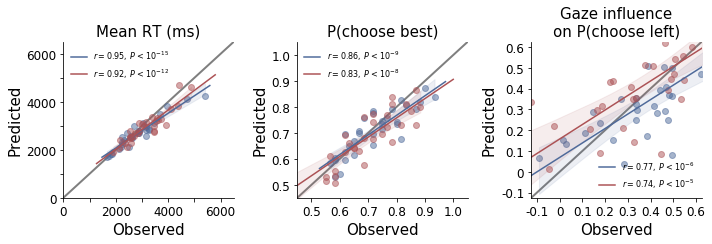

In [16]:
print('Close Figure to continue...')
figure_5(mean_rt, p_choose_best, gaze_influence)
#plt.savefig('SavedFigures/Like_model_fit_simulations.png', dpi=330, bbox_inches='tight')
plt.show()

Model predictions are simulated from hierarchically estimated parameter estimates. Blue color indicates predictions from the full GLAM, whereas orange indicates predictions from a restricted GLAM variant with no gaze bias (gamma = 1).


## ---------------------------------------------

In [26]:
import glam
import pandas as pd
import numpy as np
import os.path
import numpy
import statistics 

import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF
import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from copy import copy as copy
import operator as operator
import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob
import os



Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'pylab', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [27]:
def ttestsPlot(data1, data2,c1 ='#4F6A9A',c2 = '#AC5255',lab1 = "Like", lab2 = "Dislike",title = ''):

    # t-TEST
    diff = mean(data1) - mean(data2)
    [s, p] = stats.ttest_rel(data1,data2)
    print ("MeanL = "+ str(round(mean(data1),2))+ "; MeanD = "+ str(round(mean(data2),2))+"; [Like - Dislike] =  " + str(round(diff,2) ) +"; t =  " + str(round(s,2)) + " ; p-value =" + str(round(p,2)) )
    
        
    # PLOT LIKE AND DISLIKE VARIABILITY
        
    # Set seaborn style for the plot
    #fig = plt.figure(figsize=[6,10])
    sns.set(style='white',font_scale=1.5)
    jittr = np.random.uniform(low=-0.3,high=0.3,size=len(data1))    
    plt.scatter([1]*len(data1)+jittr, data1, c= c1, alpha=0.7,label=lab1)
    plt.scatter([2]*len(data2)+jittr, data2, c= c2, alpha=0.7,label=lab2)
    
    ## add lines between slope points in like and dislike for each participant
    
    for i in range(len(data1)):
        plt.plot( [1 + jittr[i],2 + jittr[i]], [ data1[i] , data2[i]],'--', lw=1.0, color = 'black', alpha = 0.2)

    se1 = std(data1)/sqrt(len(data1))
    se2 = std(data2)/sqrt(len(data2))

    plt.errorbar([1], [mean(data1)], yerr=se1*1.96, lw=2, color='#000000')
    plt.errorbar([2], [mean(data2)], yerr=se2*1.96, lw=2, color='#000000')
        
    plt.scatter( [1] ,  [mean(data1)] , color = c1,s=140,edgecolors = 'black', )
    plt.scatter( [2] ,  [mean(data2)] , color = c2,s=140,edgecolors = 'black', )

    #legend(loc = 'best')
    plt.xticks([1, 2,], [lab1, lab2],fontsize=25)
    plt.ylabel(title, fontsize=25)
    sns.despine()

In [28]:
gaze_influence

,observed_L,observed_D,glam_full_L,glam_full_D
0,0.270710,0.326513,0.352055,0.142079
1,-0.090946,-0.022867,0.067752,0.222105
2,0.232754,-0.047314,0.150563,0.012748
3,0.383956,0.477811,0.174120,0.395146
4,0.281868,0.163803,0.038403,0.295843
5,0.336815,0.220756,0.250027,0.431933
6,0.465908,-0.126804,0.292124,0.337479
7,0.481029,0.548371,0.368966,0.439007
8,0.681172,0.465066,0.457156,0.619502
9,0.179389,0.771615,0.234659,0.860475


MeanL = 0.39; MeanD = 0.37; [Like - Dislike] =  0.01; t =  0.39 ; p-value =0.7


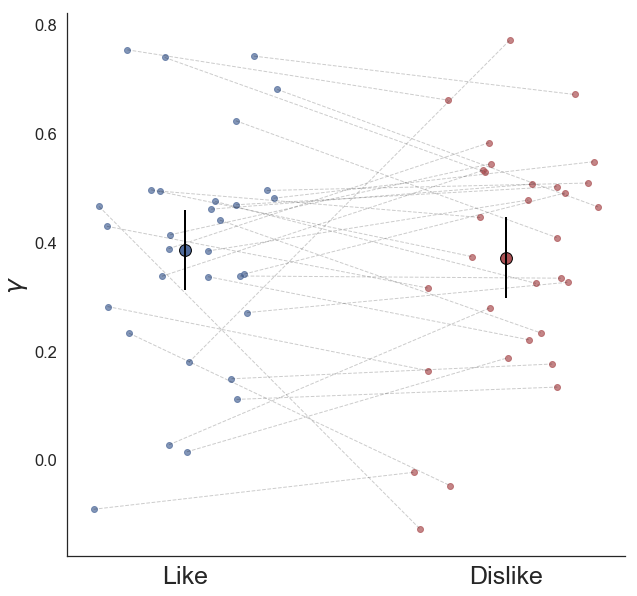

In [29]:
f = plt.figure(figsize=(10,10))
sns.set(style='white', font_scale=1.8)
ttestsPlot(gaze_influence.observed_L, gaze_influence.observed_D,'#4F6A9A','#AC5255',"Like",  "Dislike",title = '$\gamma$')

No difference in gaze influence